# Method Comparison

In [1]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"

### imports ###
import sys
import os
import pandas as pd
import numpy as np
import argparse
import matplotlib
import itertools
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy
import pickle
from sklearn import preprocessing
import sklearn
from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn import svm, datasets
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
from sklearn import ensemble
from sklearn import neighbors
import matplotlib_venn
from sklearn.cross_validation import train_test_split
from random import shuffle

### notebook specific configuration ###
%matplotlib inline
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(5000)
os.chdir('/gpfs/data01/glasslab/home/jtao/analysis/method_comparison_analysis/')
sns.set_context('notebook')
%load_ext autoreload
%autoreload 2
%env PATH=/gpfs/data01/glasslab/home/jtao/perl5/bin:/gpfs/data01/glasslab/home/jtao/software/anaconda3/bin:/home/jtao/software/bin:/usr/local/sbin:/usr/sbin:/usr/bin:/usr/local/bin:/usr/bin:/gpfs/data01/glasslab/home/jtao/software/homer/bin:/gpfs/data01/glasslab/home/jtao/software/weblogo:/home/jtao/code/seq_merge_pipe:/home/vlink/mouse_strains/marge/shifting:/bioinformatics/glassutils/scripts:/bioinformatics/software/meme/bin:/home/jtao/software/lsgkm/bin

env: PATH=/gpfs/data01/glasslab/home/jtao/perl5/bin:/gpfs/data01/glasslab/home/jtao/software/anaconda3/bin:/home/jtao/software/bin:/usr/local/sbin:/usr/sbin:/usr/bin:/usr/local/bin:/usr/bin:/gpfs/data01/glasslab/home/jtao/software/homer/bin:/gpfs/data01/glasslab/home/jtao/software/weblogo:/home/jtao/code/seq_merge_pipe:/home/vlink/mouse_strains/marge/shifting:/bioinformatics/glassutils/scripts:/bioinformatics/software/meme/bin:/home/jtao/software/lsgkm/bin


## Functions

In [2]:

def get_GC_matched_split(features, labels, test_size, tolerance = 0.01):
    '''
    feature: 2D array (samples x features)
    labels: 1D boolean array (samples x)
    test_size: fraction of data to test on
    tolerance: max difference in GC content between True and False labelled samples
    '''
    global _id_sequence_dict
    
    ### match GC content of samples labelled True with those labelled False by thowing out False samples
    # retrieve sequences using index of labels
    index_label_tuples = tuple(zip(labels.index.values, labels.values))
    
    true_sequences = [_id_sequence_dict[x[0]] for x in index_label_tuples if x[1]]
    true_ids = [x[0] for x in index_label_tuples if x[1]]
    
    false_sequences = [_id_sequence_dict[x[0]] for x in index_label_tuples if not x[1]]
    false_ids = [x[0] for x in index_label_tuples if not x[1]]
    
    # calculate GC content of True samples
    true_gc_count = 0
    true_length = 0
    for s in true_sequences:
        true_gc_count += s.count('G')
        true_gc_count += s.count('C')
        true_length += len(s)
    true_gc_content = true_gc_count/(true_length+0.0000001)
    
    # calcuate GC content of False samples
    false_gc_count = 0
    false_length = 0
    for s in false_sequences:
        false_gc_count += s.count('G')
        false_gc_count += s.count('C')
        false_length += len(s)
    false_gc_content = false_gc_count/(false_length+0.0000001)
    
    while abs(true_gc_content - false_gc_content) > tolerance:
        # remove false GC sequences until GC content matches tolerance
        selected_seq = False
        
        while not selected_seq:
            rand_index = np.random.randint(len(false_sequences))
            current_seq = false_sequences[rand_index]
            current_gc_count = current_seq.count('G')+ current_seq.count('C')
            current_length = len(current_seq)
            current_gc = current_gc_count/current_length
            if true_gc_content > false_gc_content:
                # remove sequences that would increase overall GC content of False sequences
                if current_gc < false_gc_content:
                    selected_seq = True
            else:
                # remove sequences that would decrease overall GC content of False sequences
                if current_gc > false_gc_content:
                    selected_seq = True
        false_gc_count -= current_gc_count
        false_length -= current_length
        false_gc_content = false_gc_count/false_length
        
        false_sequences.pop(rand_index)
        false_ids.pop(rand_index)
    
    filtered_ids = true_ids + false_ids
    filtered_features = features[features.index.isin(filtered_ids)]
    filtered_labels = labels[labels.index.isin(filtered_ids)]

    if test_size <= 0.5:
        training_indices, test_indices = next(iter(
                sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/test_size), shuffle=True)))
    else:
        test_indices, training_indices = next(
            iter(sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/(1-test_size)), shuffle=True)))
    training_ids = [filtered_ids[i] for i in training_indices]
    test_ids = [filtered_ids[i] for i in test_indices]
    
    training_features = filtered_features[filtered_features.index.isin(training_ids)]
    test_features = filtered_features[filtered_features.index.isin(test_ids)]
    training_labels = filtered_labels[filtered_labels.index.isin(training_ids)]
    test_labels = filtered_labels[filtered_labels.index.isin(test_ids)]
    
    return training_features, test_features, training_labels, test_labels
    

## Read in Score Files

In [3]:
motif_score_frame=pd.read_pickle('motif_score_frame_C57BL6J.pickle')
motif_sequence_frame = pd.read_pickle('motif_sequence_frame_C57BL6J.pickle')
motif_strand_frame = pd.read_pickle('motif_strand_frame_C57BL6J.pickle')
motif_start_frame = pd.read_pickle('motif_start_frame_C57BL6J.pickle')
motif_end_frame = pd.read_pickle('motif_end_frame_C57BL6J.pickle')
summary_frame = pd.read_pickle('summary_frame.pickle')
annotation_frame = pd.read_pickle('annotation_frame.pickle')

motif_summedScore_frame=pd.read_pickle('motif_summedScore_frame_C57BL6J.pickle')
# motif_summedScore_frame = motif_summedScore_frame.ix[:,3:]

# normed_motif_frame = pd.DataFrame(preprocessing.normalize(merged_motif_frame.ix[:,3:], axis=0))
scaler = preprocessing.MinMaxScaler()
normed_motif_frame = pd.DataFrame(scaler.fit_transform(motif_score_frame.ix[:,3:]))
normed_motif_frame.columns = motif_score_frame.columns.values[3:]
normed_motif_frame.index = motif_score_frame.index.values

scaler = preprocessing.MinMaxScaler()
normed_summedScore_frame = pd.DataFrame(scaler.fit_transform(motif_summedScore_frame.ix[:,3:]))
normed_summedScore_frame.columns = motif_summedScore_frame.columns.values[3:]
normed_summedScore_frame.index = motif_summedScore_frame.index.values


_factors = sorted(list(set([x.split('_')[1] for x in summary_frame.columns if '_' in x])))
_factors.remove('atac')

### read in sequences as dictionary {peakID: sequence}
with open('./C57BL6J.fa') as f:
    data = f.readlines()

_id_sequence_dict = {}
for line in data:
    if line[0] == '>':
        sequenceName = line.strip()[1:]
    else:
        _id_sequence_dict[sequenceName] = line.strip().upper()    

In [4]:
### work with just intergenic peaks for now ###
intergenic_ids = annotation_frame[annotation_frame['Annotation'] == 'Intergenic'].index.values
intergenic_motif_score_frame = motif_score_frame[motif_score_frame.index.isin(intergenic_ids)]
intergenic_motif_summedScore_frame = motif_summedScore_frame[motif_summedScore_frame.index.isin(intergenic_ids)]
intergenic_motif_sequence_frame = motif_sequence_frame[motif_sequence_frame.index.isin(intergenic_ids)]
intergenic_motif_start_frame = motif_start_frame[motif_start_frame.index.isin(intergenic_ids)]
intergenic_motif_end_frame = motif_end_frame[motif_end_frame.index.isin(intergenic_ids)]
intergenic_normed_motif_frame = normed_motif_frame[normed_motif_frame.index.isin(intergenic_ids)]
intergenic_summary_frame = summary_frame[summary_frame.index.isin(intergenic_ids)]
intergenic_annotation_frame = annotation_frame[annotation_frame.index.isin(intergenic_ids)]



In [5]:
ap1_members=['atf3', 'cjun', 'fos', 'junb', 'jund']
contains_ap1 = summary_frame[['c57bl6_'+x+'_veh' for x in ap1_members]].sum(axis=1)>0
contains_ap1_tuples = tuple(zip(contains_ap1.index.values, contains_ap1.values, summary_frame['Factors'].values))
summary_frame['Factors'] = [x[2] + ',c57bl6_ap-1_veh' if x[1] == True else x[2] for x in contains_ap1_tuples]

contains_ap1 = summary_frame[['c57bl6_'+x+'_kla' for x in ap1_members]].sum(axis=1)>0
contains_ap1_tuples = tuple(zip(contains_ap1.index.values, contains_ap1.values, summary_frame['Factors'].values))
summary_frame['Factors'] = [x[2] + ',c57bl6_ap-1_kla' if x[1] == True else x[2] for x in contains_ap1_tuples]

## Run Different Methods

In [6]:
factorPairs = []
ap1_members = ['atf3','cjun', 'fos', 'junb','jund']    
for i in range(len(ap1_members)-1):
    for j in range(i+1, len(ap1_members)):
        factorPairs.append(('c57bl6_'+ap1_members[i],'c57bl6_'+ ap1_members[j]))

In [7]:
numIterations = 5
test_size = 0.5

factors = ['atf3','cjun', 'fos', 'junb','jund', 'atac','p65']
# c57bl6_indices = summary_frame[summary_frame['Factors'].str.contains('c57bl6')].index.values  
c57bl6_indices = summary_frame[summary_frame[['c57bl6_' + x + '_veh' for x in factors]].sum(axis=1) > 0].index.values  

### Logistic Regression on Motif Scores

In [8]:
### for all peaks in vehicle for all motifs
factor_auc_dict_lr = {}

for factorPair in factorPairs:
    features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)]

    labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(
        factorPair[0] + '_veh') & summary_frame['Factors'].str.contains(factorPair[1] + '_veh')
    all_aucs = []
    for i in range(numIterations):    
        # split data into training and test sets
        training_features, test_features, training_labels, test_labels = get_GC_matched_split(
            features, labels, test_size = test_size, tolerance = 0.01)

        #  Run classifier
        lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')

        lr_classifier.fit(training_features, training_labels)
        # retrieve probabilities
        probas_lr = lr_classifier.predict_proba(test_features)
        
        # score predictions
        fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
        current_roc_auc = auc(fpr, tpr)
        all_aucs.append(current_roc_auc)
        
    mean_roc_auc = np.mean(all_aucs) # average aucROC
    print(factorPair, mean_roc_auc)
    factor_auc_dict_lr['_'.join(factorPair).replace('c57bl6_','')]= mean_roc_auc
    


('c57bl6_atf3', 'c57bl6_cjun') 0.762807206065
('c57bl6_atf3', 'c57bl6_fos') 0.837532938442
('c57bl6_atf3', 'c57bl6_junb') 0.759069175715
('c57bl6_atf3', 'c57bl6_jund') 0.772468389392
('c57bl6_cjun', 'c57bl6_fos') 0.837129036125
('c57bl6_cjun', 'c57bl6_junb') 0.770496284274
('c57bl6_cjun', 'c57bl6_jund') 0.764524993541
('c57bl6_fos', 'c57bl6_junb') 0.766515837591
('c57bl6_fos', 'c57bl6_jund') 0.832260803557
('c57bl6_junb', 'c57bl6_jund') 0.767563064205


### Logistic Regression on AP-1 Motif Score

In [9]:
### for all peaks in vehicle for all motifs
factor_auc_dict_lrAP1only = {}

for factorPair in factorPairs:
    features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)][['ap-1']]

    labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(
        factorPair[0] + '_veh') & summary_frame['Factors'].str.contains(factorPair[1] + '_veh')
    all_aucs = []
    for i in range(numIterations):    
        # split data into training and test sets
        training_features, test_features, training_labels, test_labels = get_GC_matched_split(
            features, labels, test_size = test_size, tolerance = 0.01)

        #  Run classifier
        lr_classifier = sklearn.linear_model.LogisticRegression(penalty='l1')

        lr_classifier.fit(training_features, training_labels)
        # retrieve probabilities
        probas_lr = lr_classifier.predict_proba(test_features)
        
        # score predictions
        fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
        current_roc_auc = auc(fpr, tpr)
        all_aucs.append(current_roc_auc)
        
    mean_roc_auc = np.mean(all_aucs) # average aucROC
    print(factorPair, mean_roc_auc)
    factor_auc_dict_lrAP1only['_'.join(factorPair).replace('c57bl6_','')]= mean_roc_auc
    



('c57bl6_atf3', 'c57bl6_cjun') 0.690266790808
('c57bl6_atf3', 'c57bl6_fos') 0.750978899884
('c57bl6_atf3', 'c57bl6_junb') 0.698855934822
('c57bl6_atf3', 'c57bl6_jund') 0.68889355186
('c57bl6_cjun', 'c57bl6_fos') 0.75864267945
('c57bl6_cjun', 'c57bl6_junb') 0.703088863342
('c57bl6_cjun', 'c57bl6_jund') 0.692555434643
('c57bl6_fos', 'c57bl6_junb') 0.701499938757
('c57bl6_fos', 'c57bl6_jund') 0.751441283411
('c57bl6_junb', 'c57bl6_jund') 0.69153041848


### gkmSVM (Gapped K-mer SVM)

In [8]:
!if [ ! -d ./gkmsvm_files ]; then mkdir ./gkmsvm_files; else rm ./gkmsvm_files/*; fi

('c57bl6_atf3', 'c57bl6_cjun')


/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


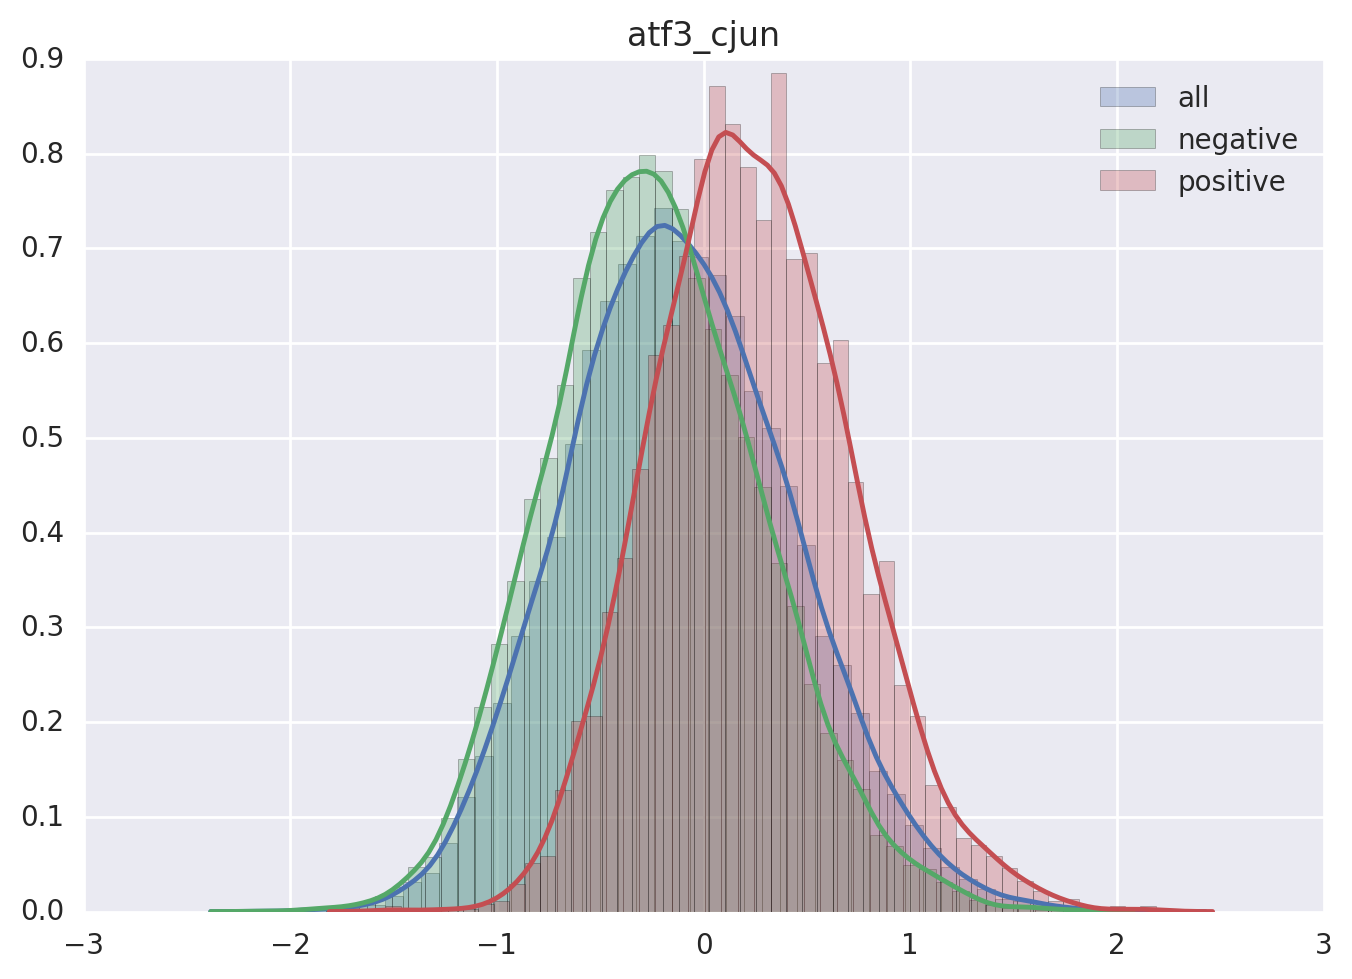

('c57bl6_atf3', 'c57bl6_fos')


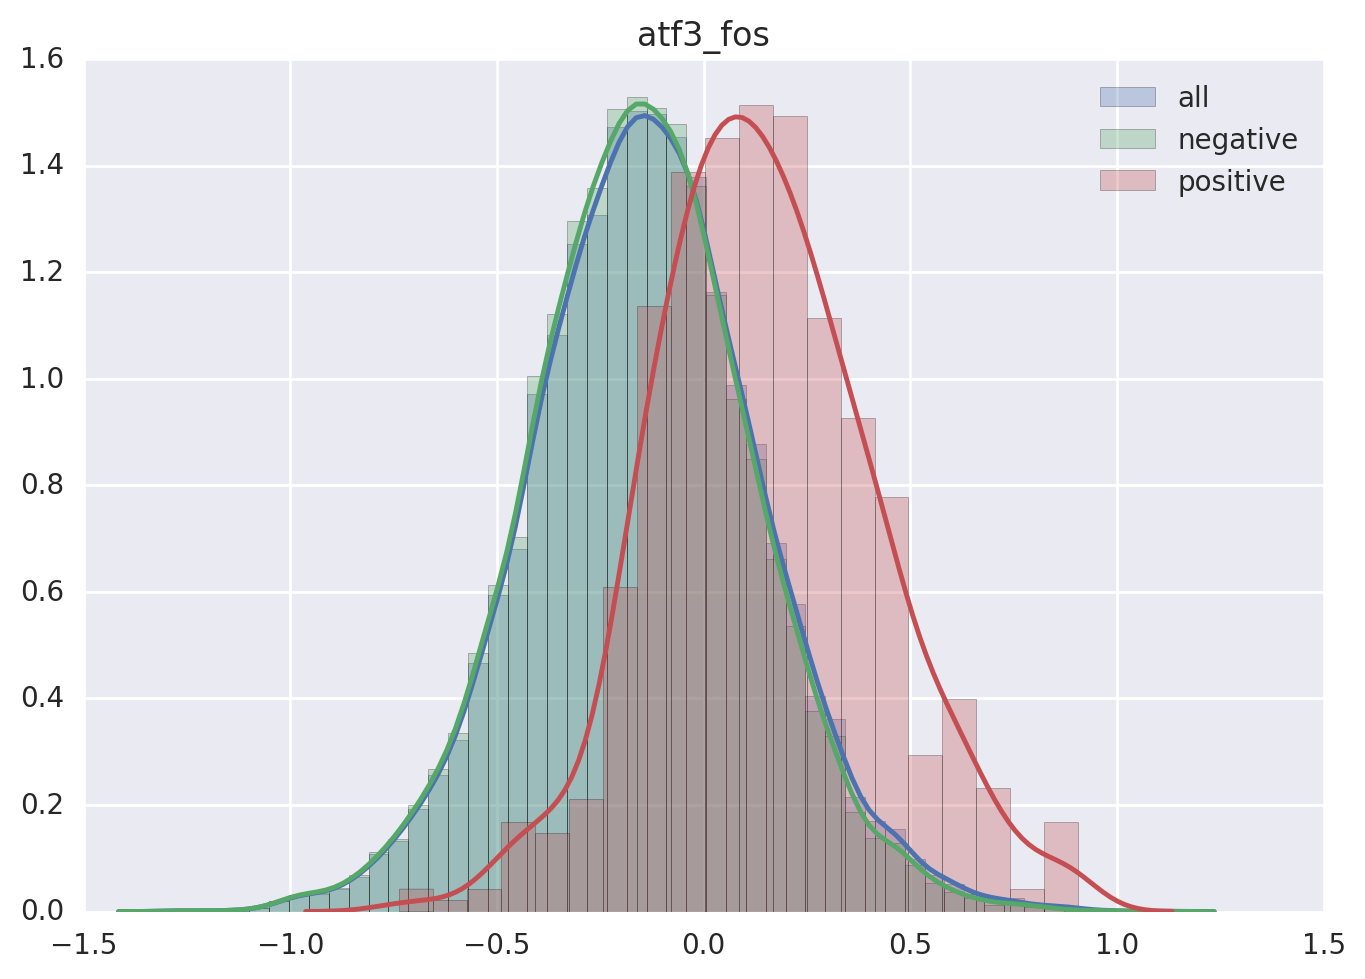

('c57bl6_atf3', 'c57bl6_junb')


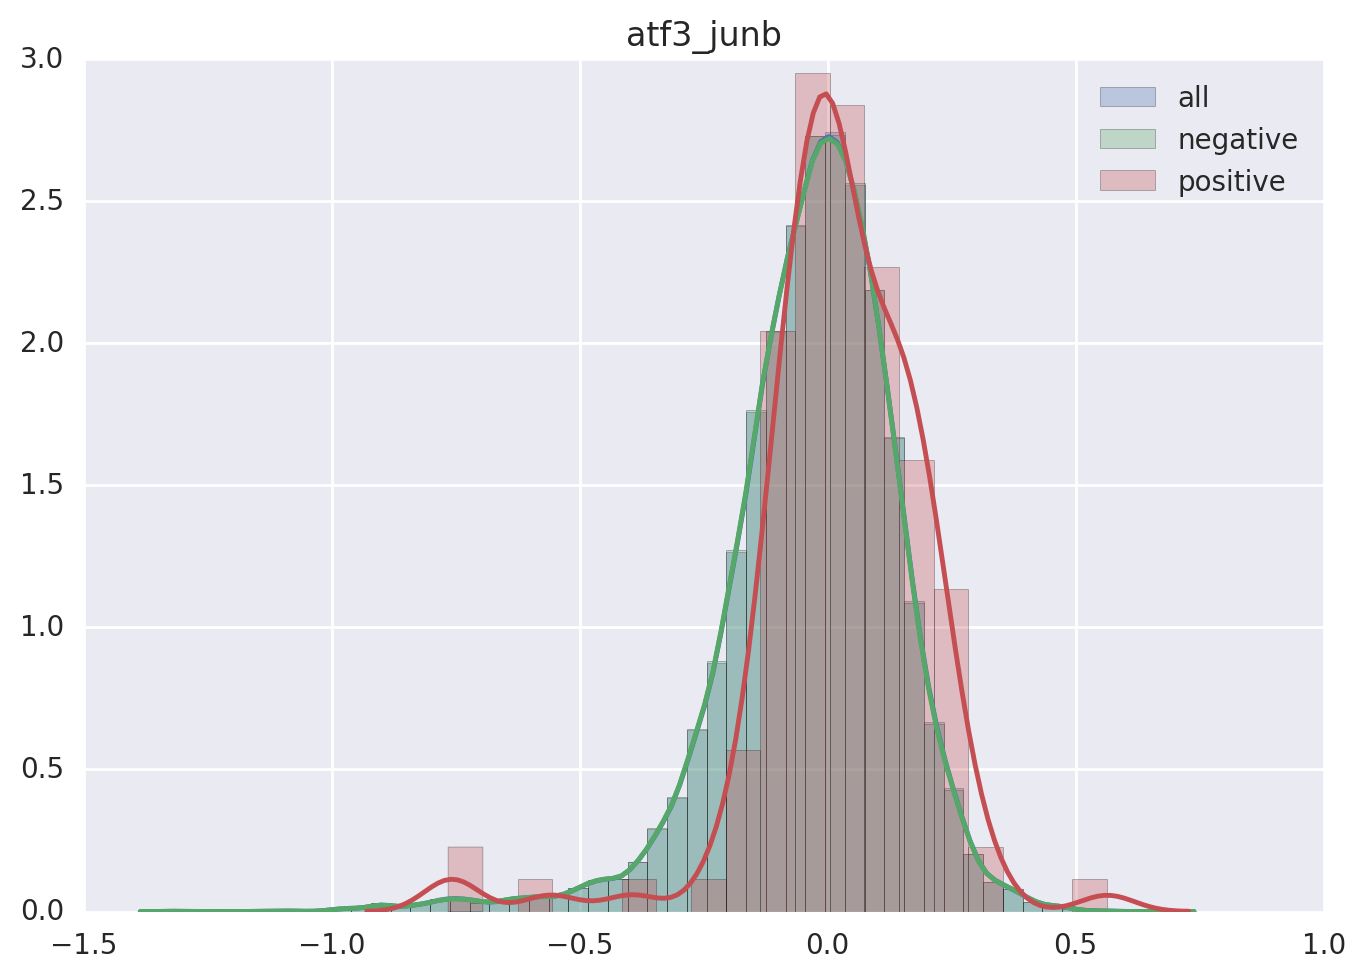

('c57bl6_atf3', 'c57bl6_jund')


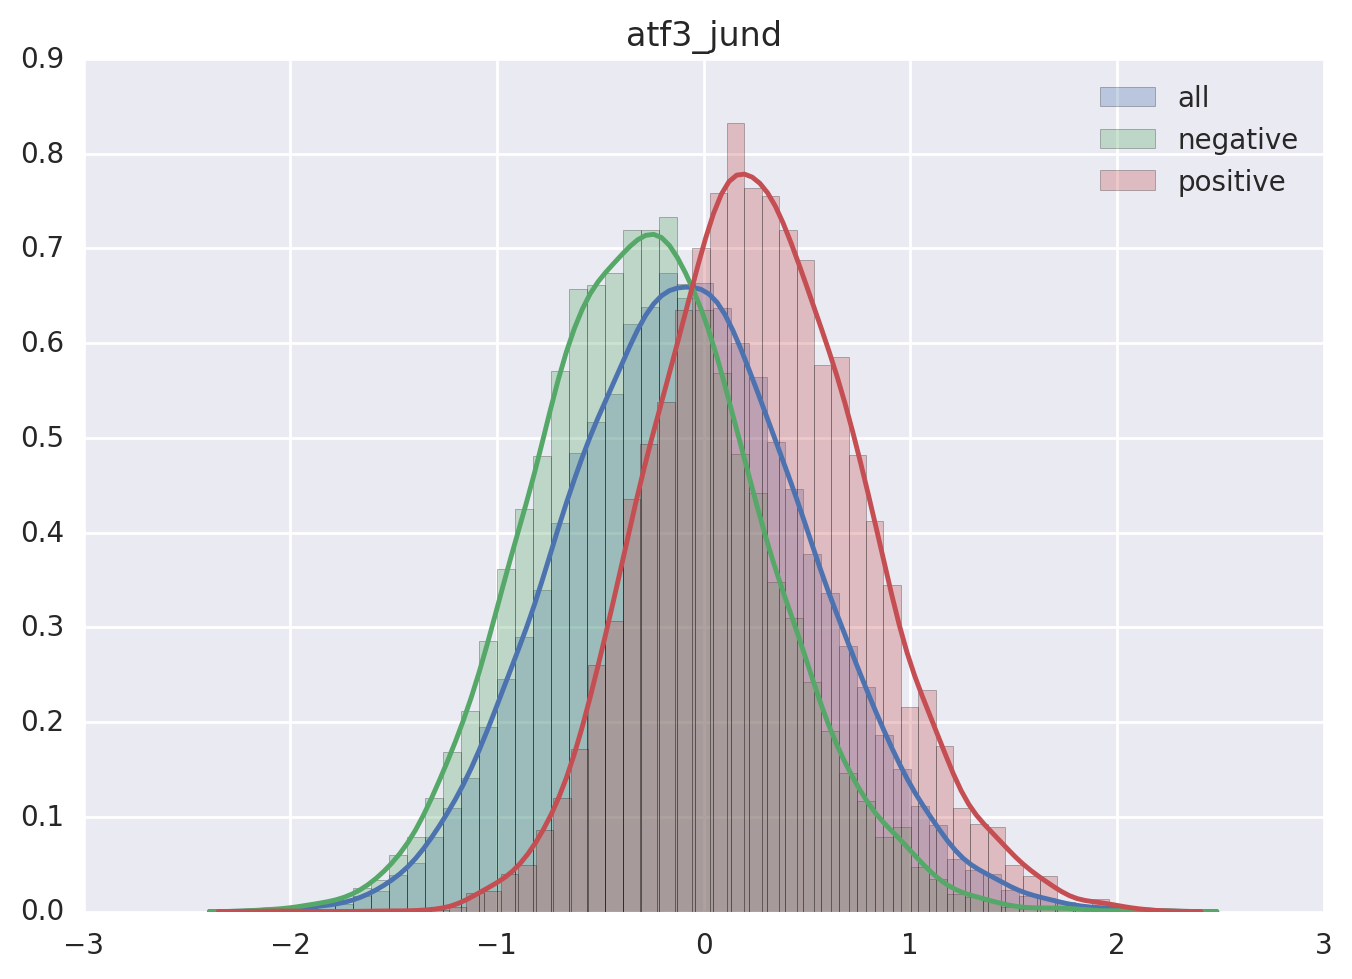

('c57bl6_cjun', 'c57bl6_fos')


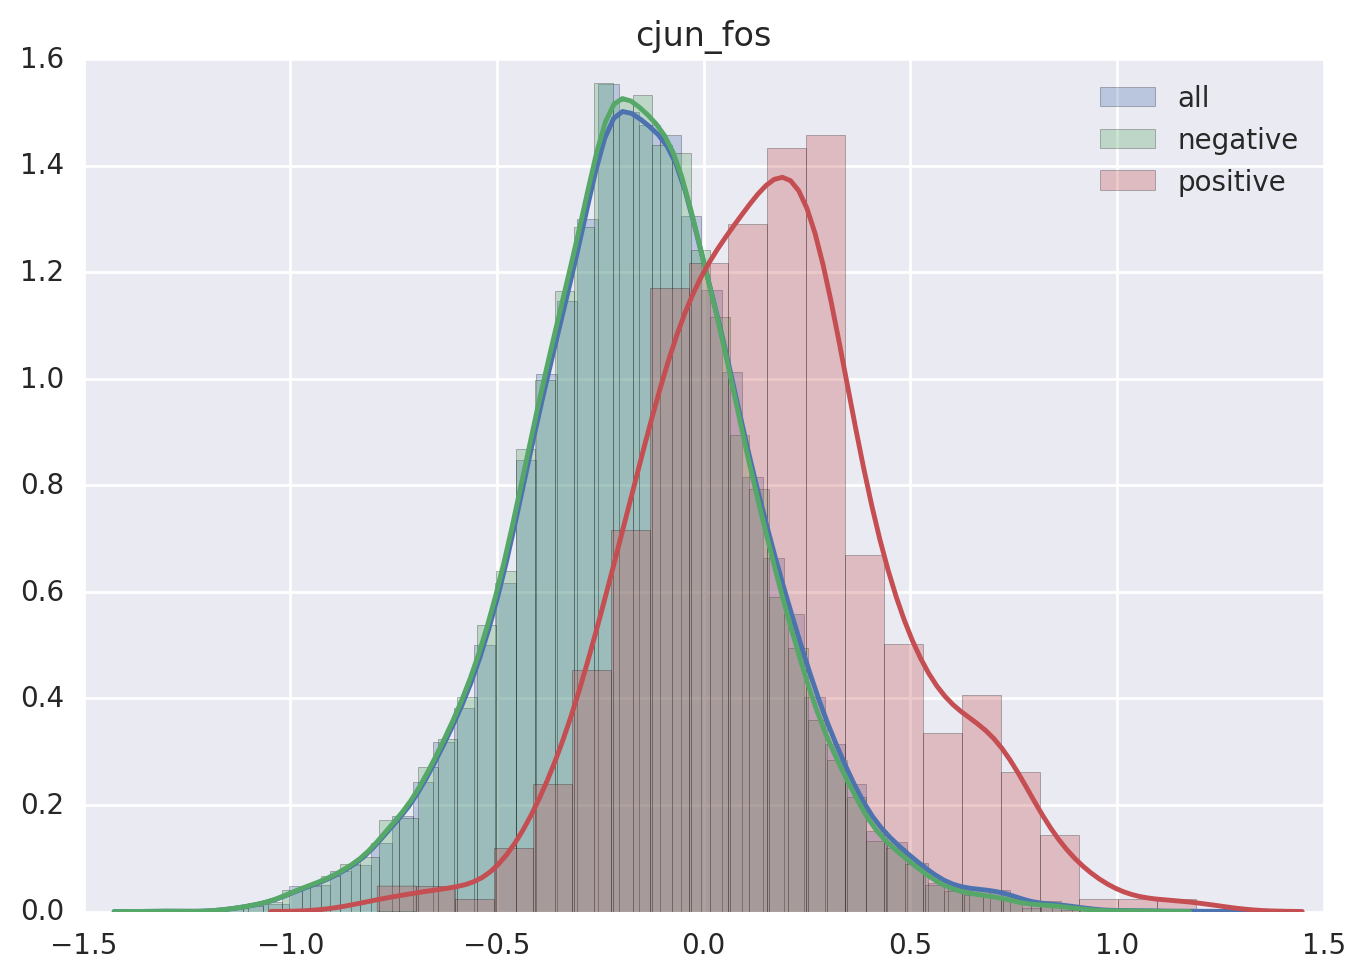

('c57bl6_cjun', 'c57bl6_junb')


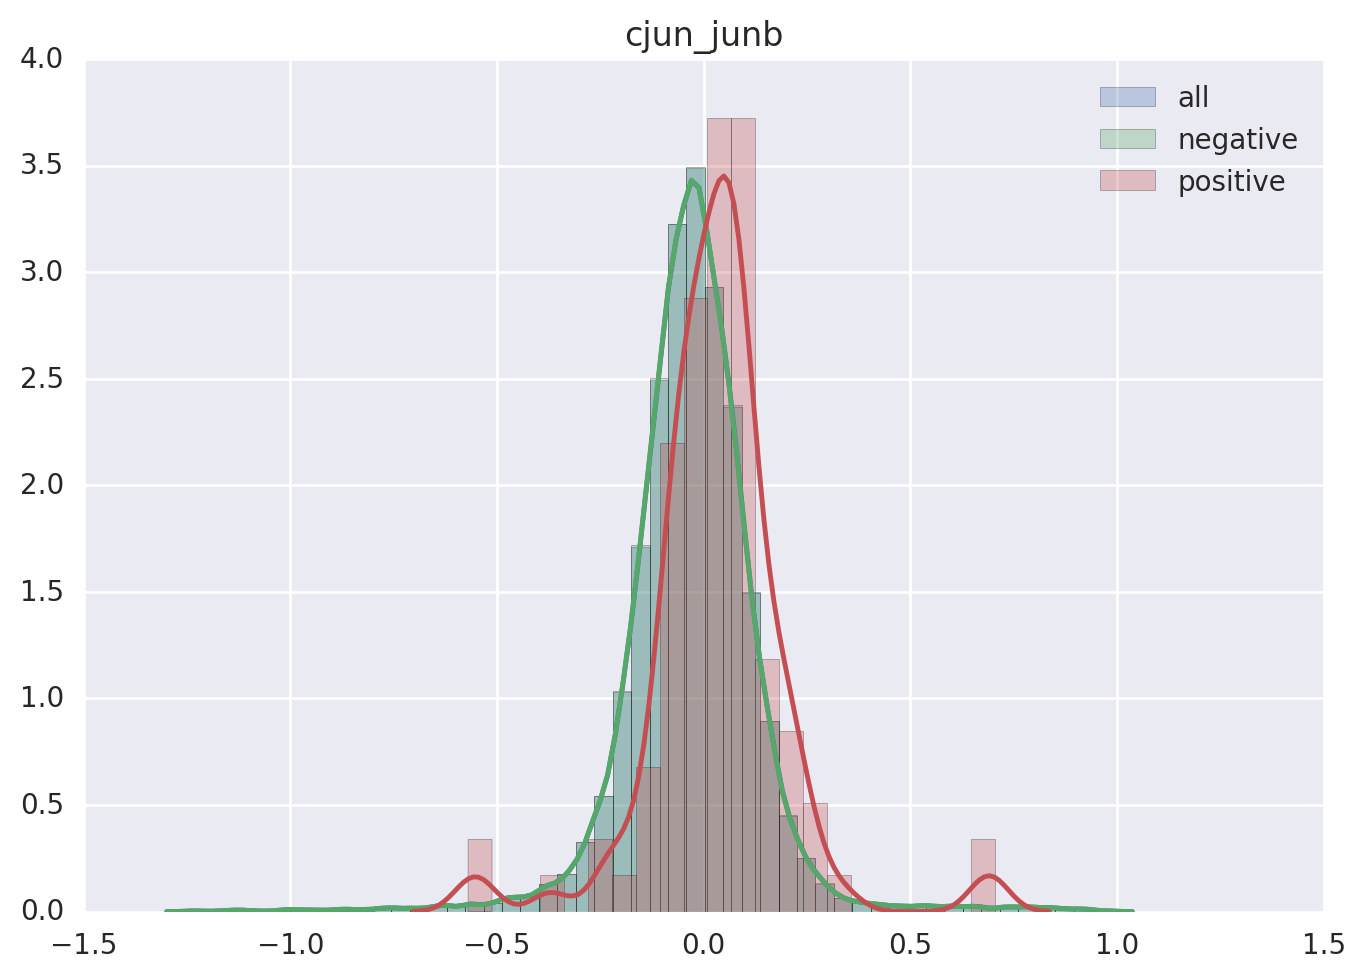

('c57bl6_cjun', 'c57bl6_jund')


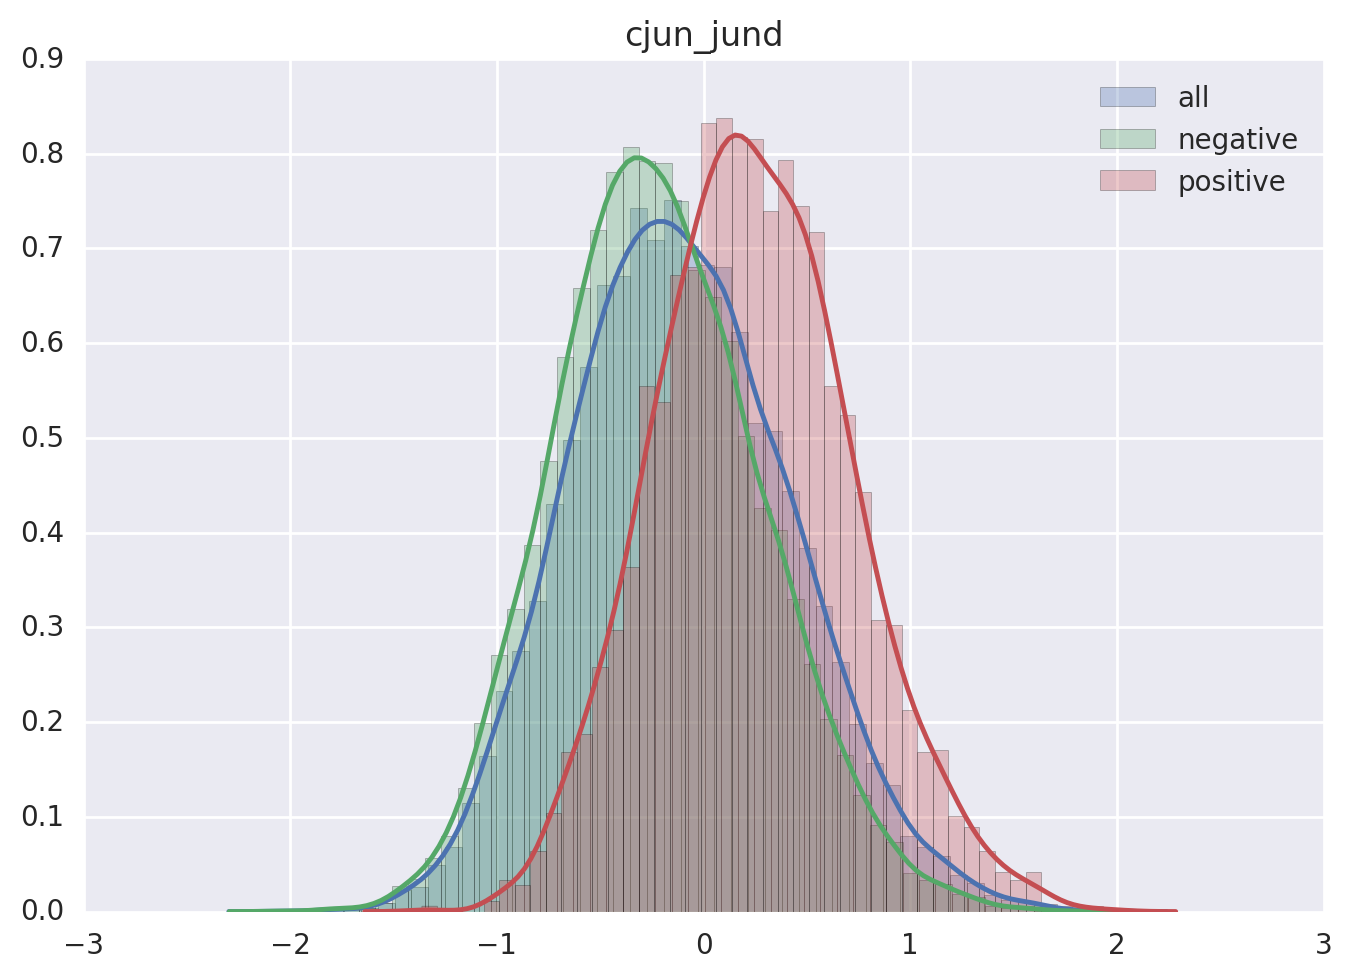

('c57bl6_fos', 'c57bl6_junb')


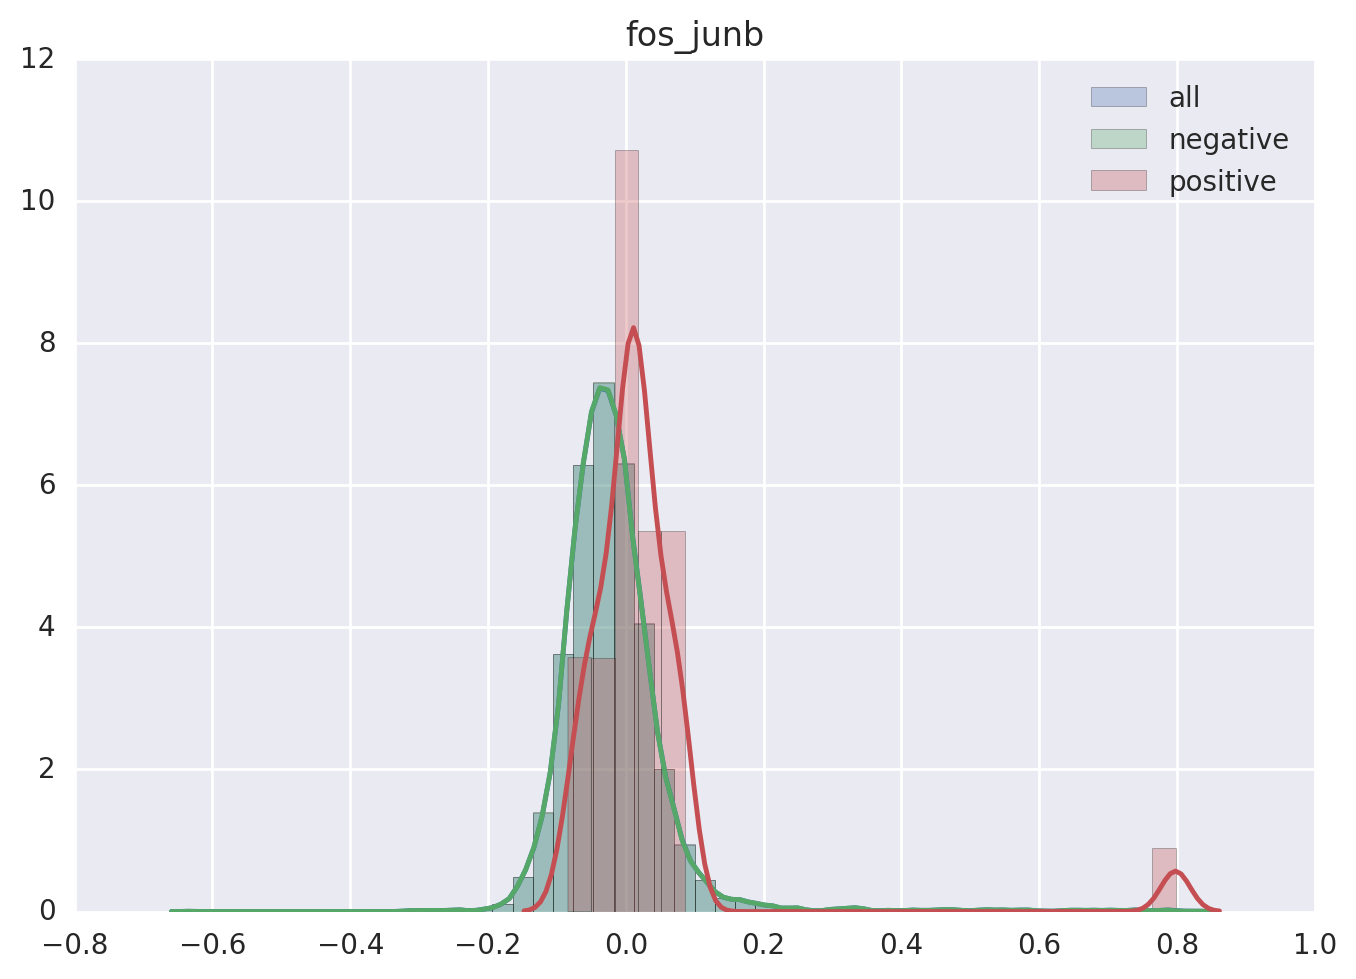

('c57bl6_fos', 'c57bl6_jund')


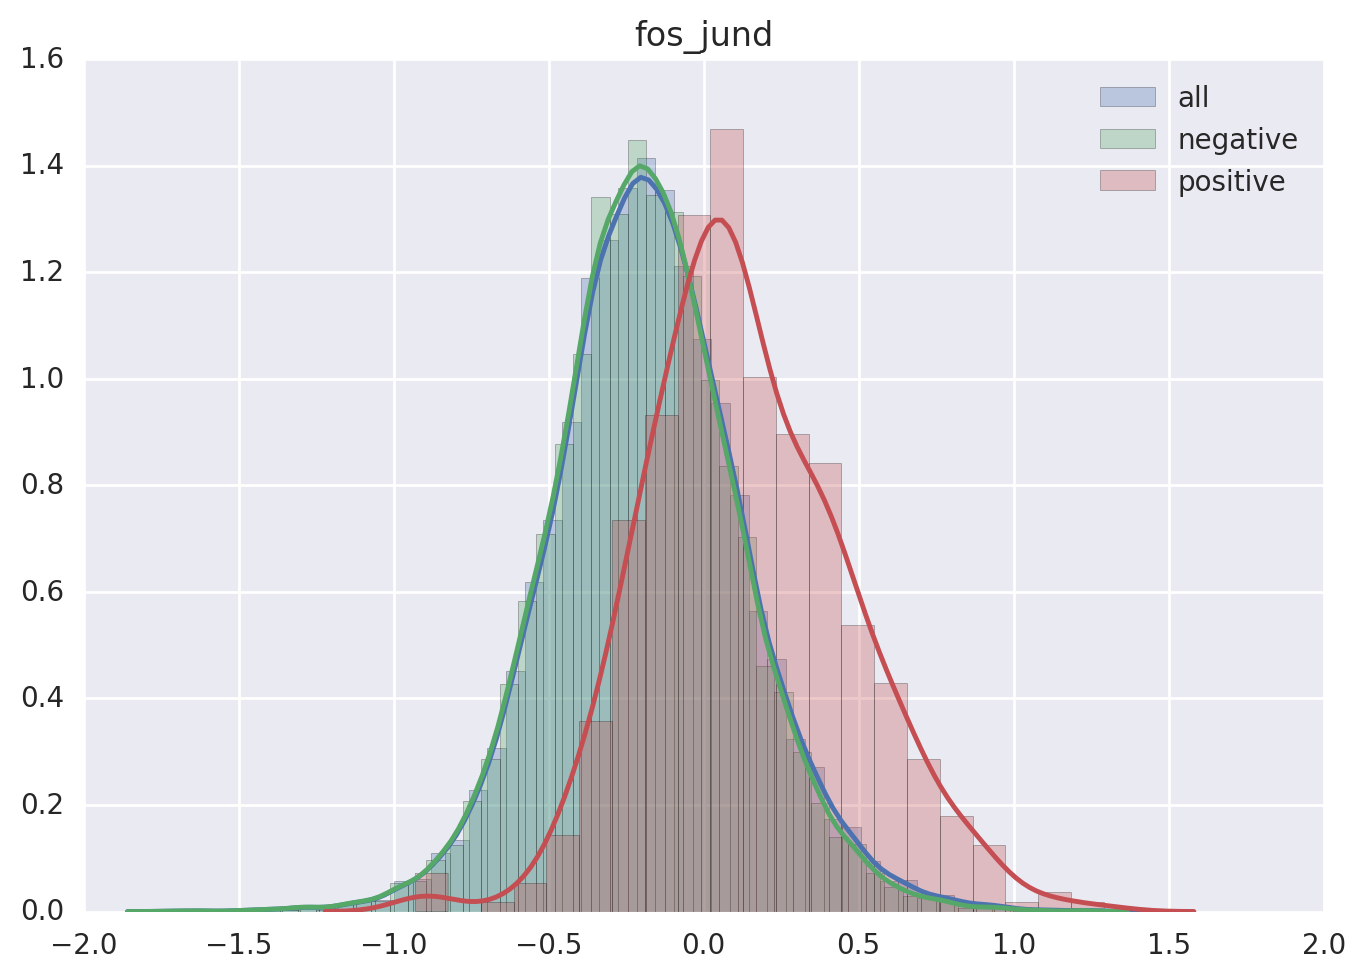

('c57bl6_junb', 'c57bl6_jund')


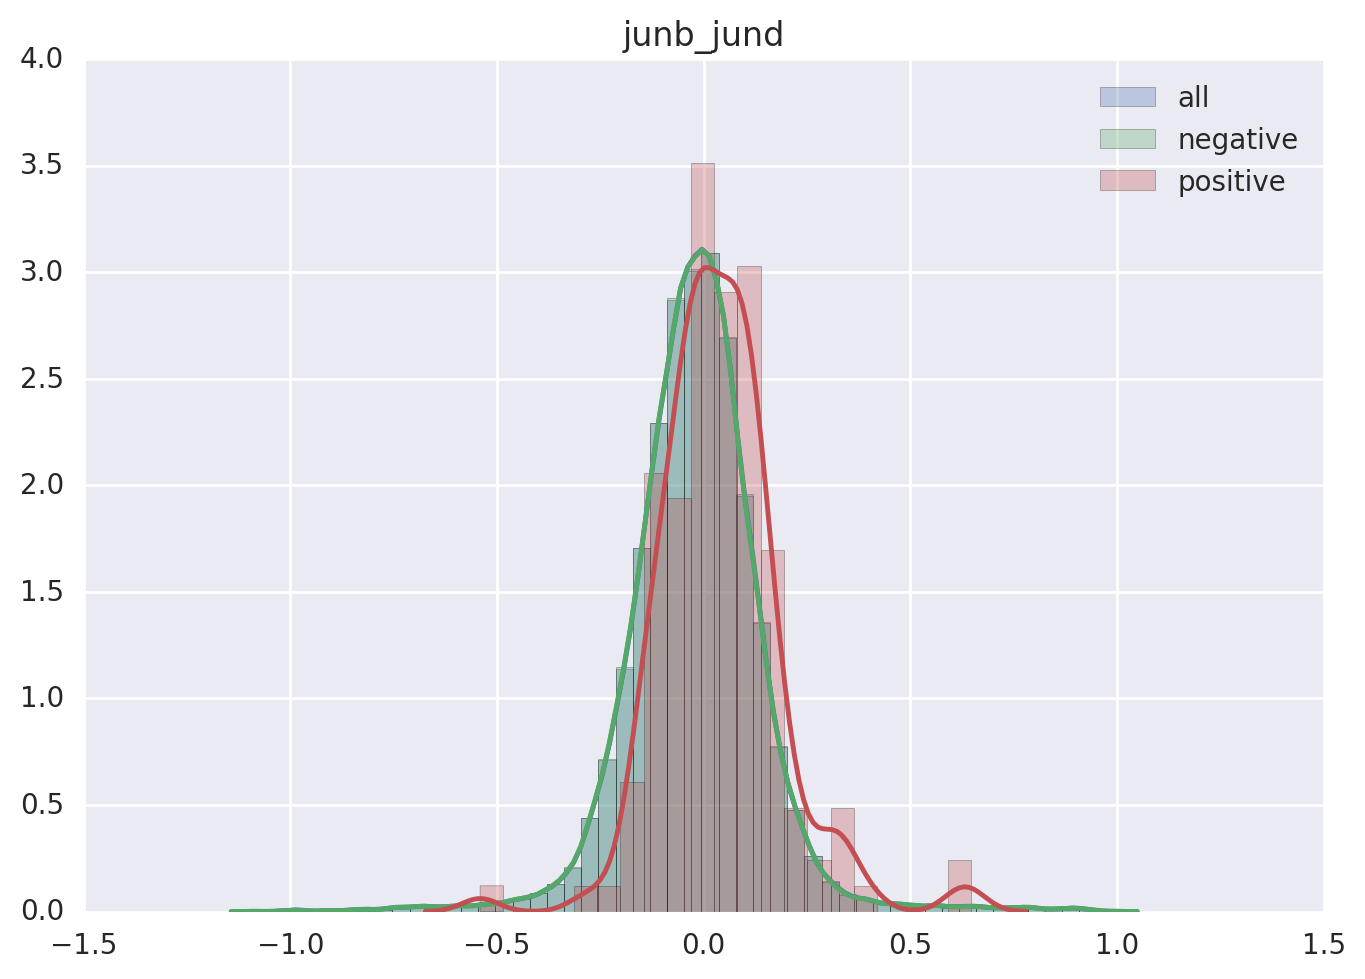

In [12]:
### for all peaks in vehicle using gapped k-mers
factor_auc_dict_gkmSVM = {}

for factorPair in factorPairs:
    print(factorPair)
    features = normed_motif_frame[normed_motif_frame.index.isin(c57bl6_indices)]

    labels = summary_frame[summary_frame.index.isin(c57bl6_indices)]['Factors'].str.contains(
        factorPair[0] + '_veh') & summary_frame['Factors'].str.contains(factorPair[1] + '_veh')
    all_aucs = []
#     for iteration in range(numIterations):    
    for iteration in [0]:
        # split data into training and test sets
        # !!!features are not used - calculated so get GC matched split will operate!!!
        training_features, test_features, training_labels, test_labels = get_GC_matched_split(
            features, labels, test_size = test_size, tolerance = 0.01)
        
        # create fasta files for positive and negative sequences
        training_positive_path = './gkmsvm_files/' + '_'.join(factorPair).replace('c57bl6_','') + '_training_positive_' +str(iteration) + '.fa'
        training_negative_path = './gkmsvm_files/' + '_'.join(factorPair).replace('c57bl6_','') + '_training_negative_' +str(iteration) + '.fa'
        training_shortNegative_path = './gkmsvm_files/' + '_'.join(factorPair).replace('c57bl6_','') + '_training_shortNegative_' +str(iteration) + '.fa'


        training_positive_file = open(training_positive_path,'w' )
        training_negative_file = open(training_negative_path,'w' )
        training_shortNegative_file = open(training_shortNegative_path,'w' )
        test_positive_path = './gkmsvm_files/' + '_'.join(factorPair).replace('c57bl6_','') + '_test_positive_' +str(iteration) + '.fa'
        test_negative_path = './gkmsvm_files/' + '_'.join(factorPair).replace('c57bl6_','') + '_test_negative_' +str(iteration) + '.fa'
        test_path = './gkmsvm_files/' + '_'.join(factorPair).replace('c57bl6_','') + '_test_' + str(iteration) + '.fa'
        
        test_positive_file = open(test_positive_path,'w' )
        test_negative_file = open(test_negative_path,'w' )
        
        test_file = open(test_path,'w')
        
        numPositiveSeqs = np.sum(training_labels)
        count=0
        for i in range(len(training_labels)):
            index = training_labels.index[i]
            label = training_labels[i]
            seq = _id_sequence_dict[index]
            if label == True:
                training_positive_file.write('>' + index + '\n')
                training_positive_file.write(seq + '\n')
            else:
                if count < numPositiveSeqs:
                    training_shortNegative_file.write('>' + index + '\n')
                    training_shortNegative_file.write(seq + '\n')
                training_negative_file.write('>' + index + '\n')
                training_negative_file.write(seq + '\n')
                count+=1

        for i in range(len(test_labels)):
            index = test_labels.index[i]
            label = test_labels[i]
            seq = _id_sequence_dict[index]
            test_file.write('>' + index + '\n')
            test_file.write(seq + '\n')
            if label == True:
                test_positive_file.write('>' + index + '\n')
                test_positive_file.write(seq + '\n')
            else:
                test_negative_file.write('>' + index + '\n')
                test_negative_file.write(seq + '\n')
        
        
        training_positive_file.close()
        training_negative_file.close()
        training_shortNegative_file.close()
        test_positive_file.close()
        test_negative_file.close()
        test_file.close()
  
        #  Run classifier
        model_prefix = './gkmsvm_files/' + '_'.join(factorPair).replace('c57bl6_','') + '_' +str(iteration)
        model_path = model_prefix + '.model.txt'
        results_path = model_prefix + '_results.txt'
        results_negative_path = model_prefix + '_results_negative.txt'
        results_positive_path = model_prefix + '_results_positive.txt'
        
#         os.system('gkmtrain '+ training_positive_path + ' ' + training_negative_path + ' ' + model_prefix +
#               ' -T 16 -m 64000')
        os.system('gkmtrain '+ training_positive_path + ' ' + training_shortNegative_path + ' ' + model_prefix +
              ' -T 16 -m 64000')
        
        os.system('gkmpredict '+ test_path + ' ' + model_path + ' ' +  results_path + ' -T 16')
        os.system('gkmpredict '+ test_negative_path + ' ' + model_path + ' ' +  results_negative_path + ' -T 16')
        os.system('gkmpredict '+ test_positive_path + ' ' + model_path + ' ' +  results_positive_path + ' -T 16')

        
        with open(results_path) as f:
            data = f.readlines()
        all_scores = []
        for line in data:
            tokens=line.strip().split()
            all_scores.append(float(tokens[1]))
        with open(results_negative_path) as f:
            data = f.readlines()
        negative_scores = []
        for line in data:
            tokens=line.strip().split()
            negative_scores.append(float(tokens[1]))
        with open(results_positive_path) as f:
            data = f.readlines()
        positive_scores = []
        for line in data:
            tokens=line.strip().split()
            positive_scores.append(float(tokens[1]))

        sns.distplot(all_scores,hist_kws={'alpha':0.3}, label = 'all')
        sns.distplot(negative_scores,hist_kws={'alpha':0.3}, label = 'negative')
        sns.distplot(positive_scores,hist_kws={'alpha':0.3}, label = 'positive')
        plt.legend()
        plt.title('_'.join(factorPair).replace('c57bl6_',''))
        plt.show()
        
#         # score predictions
#         fpr, tpr, thresholds_roc_lr = sklearn.metrics.roc_curve(test_labels, probas_lr[:, 1])
#         current_roc_auc = auc(fpr, tpr)
#         all_aucs.append(current_roc_auc)
#         break
#     mean_roc_auc = np.mean(all_aucs) # average aucROC
#     print(factorPair, mean_roc_auc)
#     factor_auc_dict_gkmSVM['_'.join(factorPair).replace('c57bl6_','')]= mean_roc_auc
    




### Classifier Performance

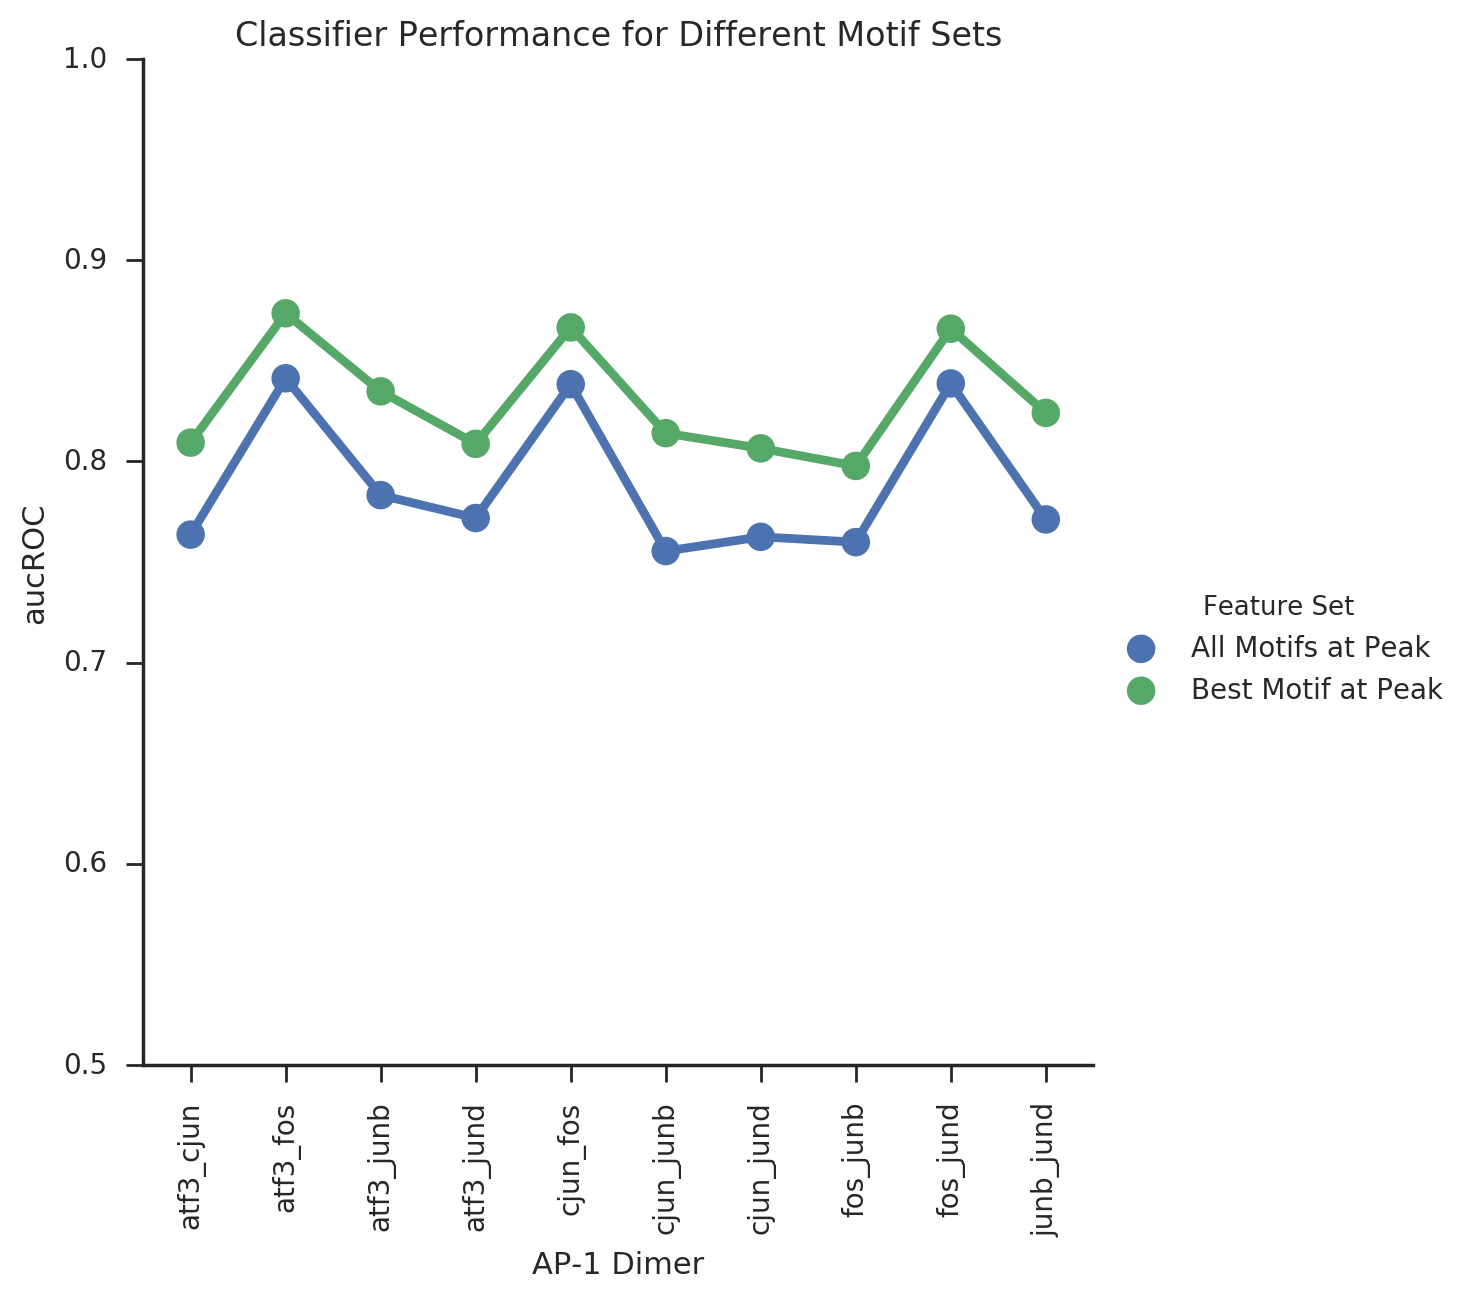

In [79]:
factors = []
aucs = []
features = []
for factor in sorted(factor_auc_dict_pairs_veh.keys()):
    factors = factors + 2 * [factor]
    features = features + [ 'All Motifs at Peak','Best Motif at Peak']
    aucs.append(factor_auc_dict_pairs_summed_veh[factor])
    aucs.append(factor_auc_dict_pairs_veh[factor])

data = pd.DataFrame({'Factor':factors,
                     'AUC':aucs,
                     'Feature Set':features})

# sort factors according to ascending AUC with all motifs


with sns.axes_style('ticks'):
    plottingFrame = sns.factorplot(data = data,
                                x='Factor',
                                y='AUC',
                                hue='Feature Set',
                                size=6)
    sns.despine()
    plt.xticks(rotation=90)
    plt.ylabel('aucROC')
    plt.xlabel('AP-1 Dimer')
    plt.ylim(0.5,1)
    plt.title('Classifier Performance for Different Motif Sets')

In [ ]:
/gpfs/data01/glasslab/home/jtao/software/lsgkm/tests

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


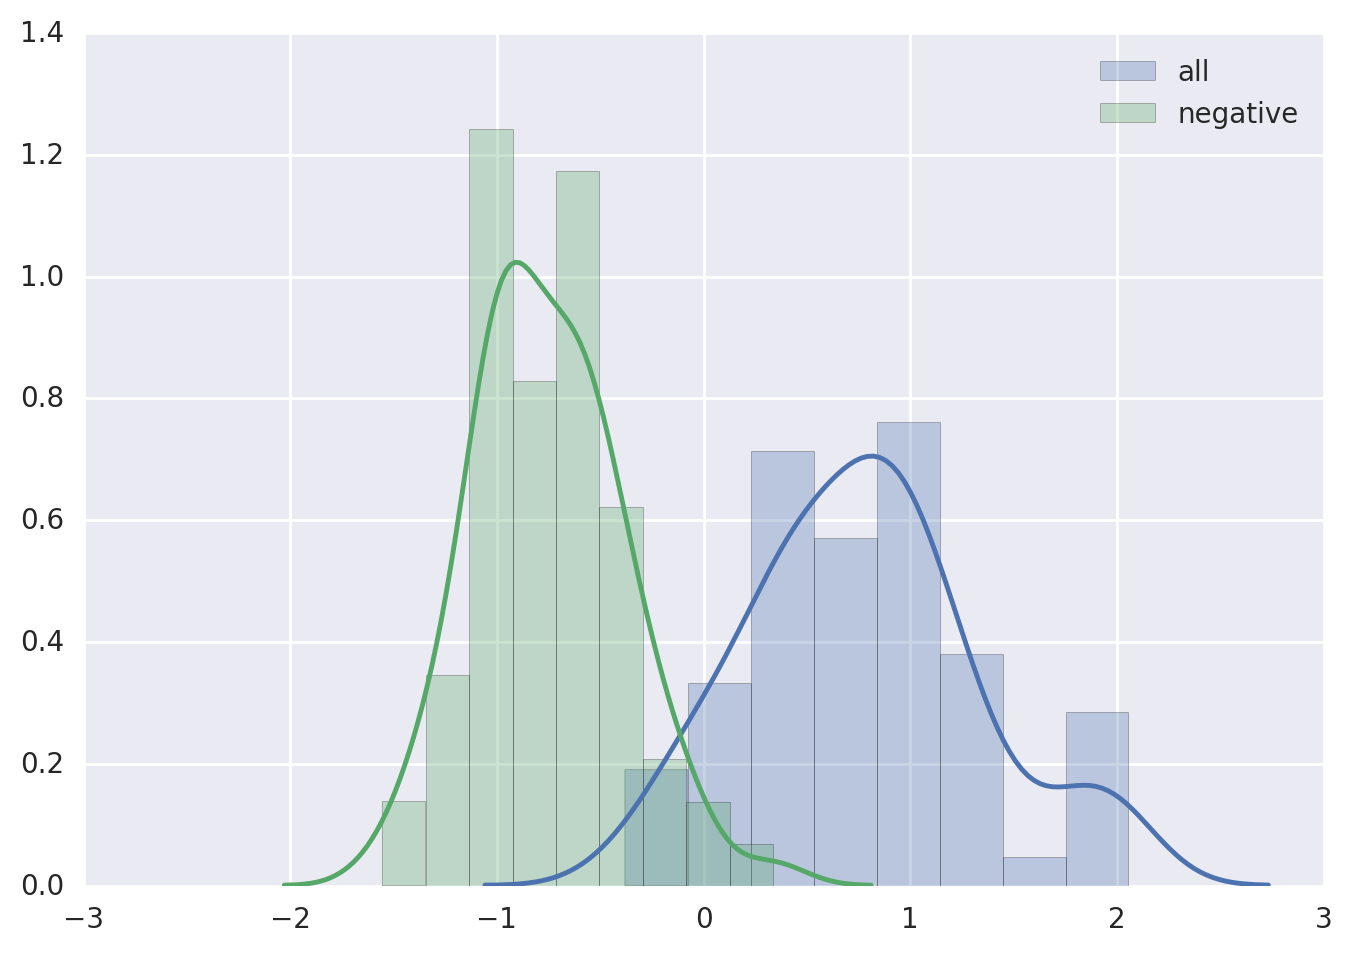

In [45]:
with open('/gpfs/data01/glasslab/home/jtao/software/lsgkm/tests/test_gkmpredict.txt') as f:
    data = f.readlines()
all_scores = []
for line in data:
    tokens=line.strip().split()
    all_scores.append(float(tokens[1]))
with open('/gpfs/data01/glasslab/home/jtao/software/lsgkm/tests/test_gkmpredict.neg.txt') as f:
    data = f.readlines()
negative_scores = []
for line in data:
    tokens=line.strip().split()
    negative_scores.append(float(tokens[1]))
# with open(results_positive_path) as f:
#     data = f.readlines()
# positive_scores = []
# for line in data:
#     tokens=line.strip().split()
#     positive_scores.append(float(tokens[1]))

sns.distplot(all_scores,hist_kws={'alpha':0.3}, label = 'all')
sns.distplot(negative_scores,hist_kws={'alpha':0.3}, label = 'negative')
# sns.distplot(positive_scores,hist_kws={'alpha':0.3}, label = 'positive')
plt.legend()